# get_rdps

This routine grabs the latest Regional Deterministic Prediction System (RDPS) model data from MSC Datamart and outputs png plots into designated product folders for each ACMWF product.

**Datamart:**

https://eccc-msc.github.io/open-data/msc-data/nwp_rdps/readme_rdps_en/

https://dd.weather.gc.ca/model_gem_regional/

**Outputs:**

12hr Total Precipitation -> *BC/AB*

Winds -> *Surface R, 1500m, 2500m*

Surface Maps -> 0-48 Hours

Temperatures -> Freezing Level R

**Maintenance:**

For bug reports, suggestions, inquiries, contact Andrew.Loeppky@gmail.com

In [1]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_title,
)

%load_ext jupyter_black

 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ WARNING: Unable to create config file               │
 │      /Users/andrew/.config/herbie/config.toml        │
 │ Herbie will use standard default settings.           │
 │ Consider setting env variable HERBIE_CONFIG_PATH.    │
 ╰──────────────────────────────────────────────────────╯



In [2]:
def plot_precip12hr(fxx, ds, config):
    """
    plots 12hr precip, saves hourly to the south coast,
    south interior, alberta rockies folders
    """

    def do_precip12h(fxx, ds, config, extent, save_path):
        """
        subfunction of plot_precip1hr designed to handle different
        map extents
        """
        fig, ax = make_figure(extent=extent)

        # plot precip rate
        pr_cmap = mpl.colors.ListedColormap(
            [
                "#CDFFCC",
                "#13F08C",
                "#05CC35",
                "#009901",
                "#FEFF65",
                "#FF9935",
                "#FE6666",
                "#FE0000",
                "#990001",
                "#9900CC",
            ]
        )
        pr_bounds = [1, 2.5, 5, 15, 25, 50, 75, 100, 150, 200]
        pr_labels = ["1", "2.5", "5", "15", "25", "50", "75", "100", "150", "200+"]
        pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
        pr = ax.pcolormesh(
            ds.longitude,
            ds.latitude,
            ds["APCP-Accum12h"].where(ds["APCP-Accum12h"] >= 1),
            cmap=pr_cmap,
            norm=pr_norm,
            antialiased=True,
            transform=pc,
        )

        # precip colorbar
        fig.text(
            0.062,
            0.848,
            "(mm)",
            color="black",
            size=15,
            transform=ax.transAxes,
            ha="center",
        )
        fig.text(
            0.06,
            0.85,
            "(mm)",
            color="white",
            size=15,
            transform=ax.transAxes,
            ha="center",
        )
        pr_cbar = fig.colorbar(
            pr,
            cmap=pr_cmap,
            norm=pr_norm,
            ax=ax,
            spacing="uniform",
            shrink=0.35,
            location="left",
            aspect=9,
            anchor=(0.13, 0.65),
            pad=-0.15,
        )
        pr_cbar.ax.tick_params(
            labelsize=15,
            labelcolor="white",
            length=0,
            labelright=True,
            labelleft=False,
        )
        pr_cbar.ax.set_yticklabels(pr_labels)

        # cities
        plot_cities(ax, extent=extent)

        # title
        make_title(fig, ax, ds, "Total Precip - 12h")

        # save and close
        fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
        fig.clf()

        return None

    # BC/AB
    path = os.path.join(
        config["plots"]["12hpcp_bcab"],
        f"pcp12hr_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
    )
    do_precip12h(fxx, ds, config, "BC-AB", path)

    return None

In [3]:
def plot_surf(fxx, ds, config):
    """
    plots the surface figure for mwf day 3-4, surface 0-48h
    """
    fig, ax = make_figure(extent="BC-AB")

    # plot height contours
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.prmsl,
        colors="k",
        transform=pc,
        levels=range(900, 1100, 4),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot thickness contours
    th_cmap = mpl.colors.ListedColormap(
        [
            "pink",
            "blue",
            "orange",
        ]
    )
    th_bounds = [4800, 5100, 5400, 5700]
    th_norm = mpl.colors.BoundaryNorm(th_bounds, th_cmap.N)
    ht = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.thick,
        cmap=th_cmap,
        norm=th_norm,
        linestyles="dashed",
        transform=pc,
        levels=range(4000, 6000, 60),
    )
    ax.clabel(ht, inline=True, fontsize=9)

    # plot cloud cover
    cc_cmap = mpl.colors.ListedColormap(["#FFFFFF", "#999999"])
    cc_bounds = [60, 80, 100]
    cc_norm = mpl.colors.BoundaryNorm(cc_bounds, cc_cmap.N)
    cc = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.TCDC.where(ds.TCDC >= 60),
        cmap=cc_cmap,
        norm=cc_norm,
        antialiased=True,
        transform=pc,
    )

    # plot precip rate
    pr_cmap = mpl.colors.ListedColormap(
        [
            "#99FF99",
            "#33FE35",
            "#33FE35",
            "#008001",
            "#FEFF00",
            "#FFCC02",
            "#FF989A",
            "#FE0000",
            "#DC0E8C",
            "#660066",
        ]
    )
    pr_bounds = [0.2, 1, 2, 5, 10, 15, 20, 30, 45, 60, 80]
    pr_labels = ["0.2", "1", "2", "5", "10", "15", "20", "30", "45", "60", "80+"]
    pr_norm = mpl.colors.BoundaryNorm(pr_bounds, pr_cmap.N)
    pr = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.prate.where(ds.prate >= 0.2),
        cmap=pr_cmap,
        norm=pr_norm,
        antialiased=True,
        transform=pc,
    )

    # precip colorbar
    fig.text(
        0.062,
        0.848,
        "3hr Pcpn",
        color="black",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )
    fig.text(
        0.06,
        0.85,
        "3hr Pcpn",
        color="white",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )

    fig.text(
        0.062,
        0.818,
        "(mm)",
        color="black",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )
    fig.text(
        0.06,
        0.82,
        "(mm)",
        color="white",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )

    pr_cbar = fig.colorbar(
        pr,
        cmap=pr_cmap,
        norm=pr_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.4,
        location="left",
        aspect=10,
        anchor=(0.15, 0.65),
        pad=-0.135,
    )
    pr_cbar.ax.tick_params(
        labelsize=15,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    pr_cbar.ax.set_yticklabels(pr_labels)

    # cloud cover colorbar
    fig.text(
        0.062,
        0.298,
        "Cloud\nCover",
        color="black",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )
    fig.text(
        0.06,
        0.3,
        "Cloud\nCover",
        color="white",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )

    fig.text(
        0.062, 0.278, "(%)", color="black", size=15, transform=ax.transAxes, ha="center"
    )
    fig.text(
        0.06, 0.28, "(%)", color="white", size=15, transform=ax.transAxes, ha="center"
    )

    cc_cbar = fig.colorbar(
        cc,
        cmap=cc_cmap,
        norm=cc_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.125,
        location="left",
        aspect=3,
        anchor=(0, 0.15),
        pad=-0.17,
    )
    cc_cbar.ax.tick_params(
        labelsize=15,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )

    make_title(fig, ax, ds, "Surface")

    # save and close the figure
    fig.savefig(
        os.path.join(
            config["plots"]["surf"],
            f"surf_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
        pad_inches=0,
    )
    fig.clf()

    return None

In [4]:
def plot_10m_wind(fxx, ds, config):
    """
    plots 10m wind

    """
    fig, ax = make_figure(extent="BC-AB")

    # plot wind velocity
    w_cmap = mpl.colors.ListedColormap(
        [
            "#FFFFFF",
            "#CCCCCC",
            "#CD97D0",
            "#995B99",
            "#080099",
            "#3334FF",
            "#00CC00",
            "#FEFF00",
            "#FE9A00",
            "#CB0000",
            # "#FF00CC",
        ]
    )
    w_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    w_labels = ["0", "10", "20", "30", "40", "50", "60", "70", "80", "90", "100+"]
    w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N)
    w = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.wind,
        cmap=w_cmap,
        norm=w_norm,
        antialiased=True,
        transform=pc,
    )

    # plot pressure contours
    ps = ax.contour(
        ds.longitude,
        ds.latitude,
        ds.prmsl,
        colors="k",
        transform=pc,
        levels=range(900, 1100, 4),
    )
    ax.clabel(ps, inline=True, fontsize=9)

    # units
    fig.text(
        0.062,
        0.848,
        "(km/h)",
        color="black",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )
    fig.text(
        0.06,
        0.85,
        "(km/h)",
        color="white",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )

    # wind vel colorbar
    w_cbar = fig.colorbar(
        w,
        cmap=w_cmap,
        norm=w_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.55,
        location="left",
        aspect=14,
        anchor=(0.15, 0.55),
        pad=-0.15,
    )
    w_cbar.ax.tick_params(
        labelsize=15,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    w_cbar.ax.set_yticklabels(w_labels)

    # wind direction arrows
    ax.quiver(
        ds.longitude,
        ds.latitude,
        ds.u10 / ds.wind,
        ds.v10 / ds.wind,
        transform=pc,
        regrid_shape=30,
        pivot="mid",
        width=0.0015,
        color="white",
    )

    make_title(fig, ax, ds, "Surface Wind")

    # save and close the figure
    fig.savefig(
        os.path.join(
            config["plots"]["wind_surf"],
            f"wind10m_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
        pad_inches=0,
    )
    fig.clf()

    return None

In [5]:
def plot_upper_wind(fxx, ds, config, height):
    """
    plots streamline wind figure (1500m and 2500m)
    height: either "1500" or "2500"
    """
    fig, ax = make_figure(extent="BC-AB")

    # plot wind velocity
    w_cmap = mpl.colors.ListedColormap(
        [
            "#E3E6D9",
            "#BAE591",
            "#6AB3A0",
            "#5992B8",
            "#4A56A2",
        ]
    )
    w_bounds = [25, 40, 60, 90, 120]
    w_labels = ["25", "40", "60", "90", "120+"]
    w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N)
    w = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.wind.where(ds.wind >= 25),
        cmap=w_cmap,
        norm=w_norm,
        antialiased=True,
        transform=pc,
    )

    fig.text(
        0.062,
        0.848,
        "(km/h)",
        color="black",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )
    fig.text(
        0.06,
        0.85,
        "(km/h)",
        color="white",
        size=15,
        transform=ax.transAxes,
        ha="center",
    )

    # wind vel colorbar
    w_cbar = fig.colorbar(
        w,
        cmap=w_cmap,
        norm=w_norm,
        ax=ax,
        spacing="uniform",
        shrink=0.45,
        location="left",
        aspect=10,
        anchor=(0.15, 0.55),
        pad=-0.15,
    )
    w_cbar.ax.tick_params(
        labelsize=15,
        labelcolor="white",
        length=0,
        labelright=True,
        labelleft=False,
    )
    w_cbar.ax.set_yticklabels(w_labels)

    # streamplot wind direction
    strm = ax.streamplot(
        ds.longitude,
        ds.latitude,
        ds.u,
        ds.v,
        transform=pc,
        color="white",
        density=2,
        linewidth=0.6,
        arrowsize=1.5,
    )

    make_title(fig, ax, ds, f"Wind\n{height} metres")

    # save and close the figure
    fig.savefig(
        os.path.join(
            config["plots"][f"wind_{height}m"],
            f"wind{height}m_{ds.model}_{pd.Timestamp(ds.time.values).strftime('%Y_%_h_%d')}_{pd.Timestamp(ds.time.values).strftime('%H')}Z_P{fxx}",
        ),
        bbox_inches="tight",
        pad_inches=0,
    )
    fig.clf()

    return None

In [6]:
def do_wind(run, fxx, config):
    """
    create wind plots in a memory efficient way
    """
    # clear the rdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]

    # get all the 10m wind data and merge it
    u10 = get_var(run, "rdps", fxx, "UGRD", "TGL_10")
    v10 = get_var(run, "rdps", fxx, "VGRD", "TGL_10")
    pres = get_var(run, "rdps", fxx, "PRMSL", "MSL_0")
    ds = xr.merge([u10, v10, pres])

    # convert sea level pressure to hPa
    ds["prmsl"] /= 100

    # convert wind from m/s to km/h
    ds["u10"] *= 3.6
    ds["v10"] *= 3.6

    # calculate abs value of windspeed
    ds["wind"] = (ds["u10"] ** 2 + ds["v10"] ** 2) ** 0.5

    plot_10m_wind(fxx, ds, config)
    
    # do upper winds every 6h
    if fxx % 6 == 0:
        # clear the rdps data folder again, get 850mb wind for 1500m graphic
        clear_dir = [clear_directory(file) for file in list(config["data"].values())]
        u850 = get_var(run, "rdps", fxx, "UGRD", "ISBL_850")
        v850 = get_var(run, "rdps", fxx, "VGRD", "ISBL_850")
        ds = xr.merge([u850, v850])

        # convert wind from m/s to km/h
        ds["u"] *= 3.6
        ds["v"] *= 3.6

        # calculate abs value of windspeed
        ds["wind"] = (ds["u"] ** 2 + ds["v"] ** 2) ** 0.5

        # 1500m graphic
        plot_upper_wind(fxx, ds, config, "1500")

        # clear the rdps data folder again, get 750mb wind for 2500m graphic
        clear_dir = [clear_directory(file) for file in list(config["data"].values())]
        u750 = get_var(run, "rdps", fxx, "UGRD", "ISBL_750")
        v750 = get_var(run, "rdps", fxx, "VGRD", "ISBL_750")
        ds = xr.merge([u750, v750])

        # convert wind from m/s to km/h
        ds["u"] *= 3.6
        ds["v"] *= 3.6

        # calculate abs value of windspeed
        ds["wind"] = (ds["u"] ** 2 + ds["v"] ** 2) ** 0.5

        # 2500m graphic
        plot_upper_wind(fxx, ds, config, "2500")

    return None

In [7]:
def do_rdps(run, fxx, config):
    """
    creates all rdps dependent plots for forecast time fxx
    """
    # clear the rdps data folder
    clear_dir = [clear_directory(file) for file in list(config["data"].values())]
    # heights to pull geopotentials
    hgt = ["ISBL_1000", "ISBL_500"]

    # get all the data and merge it into one big xarray
    temp = get_var(run, "rdps", fxx, "TMP", "TGL_2")
    height = xr.concat(
        [get_var(run, "rdps", fxx, "HGT", h) for h in hgt], dim="isobaricInhPa"
    )
    pres = get_var(run, "rdps", fxx, "PRMSL", "MSL_0")
    tcdc = get_var(run, "rdps", fxx, "TCDC", "SFC_0")
    prate = get_var(run, "rdps", fxx, "PRATE", "SFC_0")

    # 12hr accumulation after forecast hour 12 in 6 hr increments
    if (fxx >= 12) and (fxx % 6 == 0):
        pcp12h = get_var(run, "rdps", fxx, "APCP-Accum12h", "SFC_0")
        ds = xr.merge([temp, tcdc, prate, height, pres, pcp12h])
    else:
        ds = xr.merge([temp, tcdc, prate, height, pres])

    # convert precip from kg/m3/s to mm/3h
    ds["prate"] *= 3600 * 3

    # convert sea level pressure to hPa
    ds["prmsl"] /= 100

    # convert temps from kelvin to degC
    ds["t2m"] -= 273.15

    # calculate 1000 - 500mb thickness
    ds["thick"] = ds.gh.loc[{"isobaricInhPa": 500}] - ds.gh.loc[{"isobaricInhPa": 1000}]

    # generate plots
    plot_surf(fxx, ds, config)
    if (fxx >= 12) and (fxx % 6 == 0):
        plot_precip12hr(fxx, ds, config)

    # run wind function separately to conserve memory
    do_wind(run, fxx, config)

    return ds

In [8]:
def main(tstep=range(3, 49, 3)):
    """
    main function to generate all rdps plots for a forecast run
    (default 48h with 1h increments)
    """
    # time of last model run (0000, 0600, 1200, 1800 Z)
    now = pd.Timestamp.utcnow().floor("6h").tz_localize(None)

    # config determines the directories in which to save each graphic
    with open("..//config/rdps_config.json") as f:
        config = json.load(f)

    clear_dir = [clear_directory(file) for file in list(config["plots"].values())]
    ds = [do_rdps(now, fxx, config) for fxx in tstep]

    return ds

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F10 ┊ GRIB2 @ msc ┊ IDX @ None


✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F19 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/gri

✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/rdps/20250615]
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F28 ┊ GRIB2 @ msc ┊ IDX @ None
✅ Found ┊ model=rdps ┊ product=10km/grib2/ ┊ 2025-Jun-15 00:00 UTC F31 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/

KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

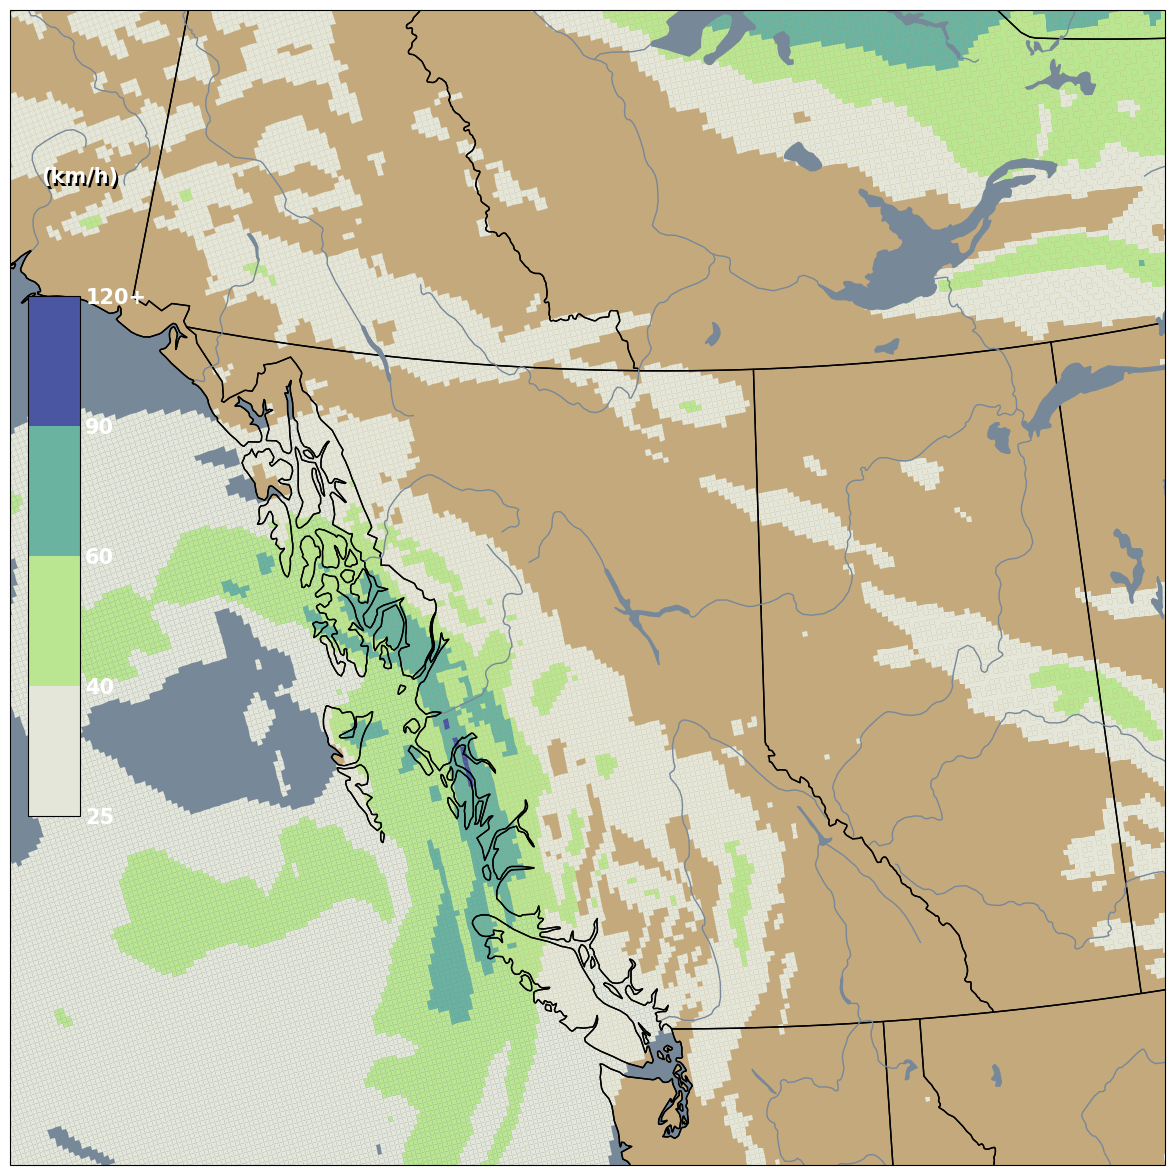

In [9]:
if __name__ == "__main__":
    ds = main()